In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from scipy.stats import skew

In [213]:
df=pd.read_csv('structured_data.csv')
df.head()

,CustomerKey,Customer ID,OrderDateKey,Date,SalesOrderLineKey,Sales Order,Sales Amount
0,-1,[Not Applicable],20170702,7/2/2017,43659001,SO43659,"$2,024.99"
1,-1,[Not Applicable],20170702,7/2/2017,43659002,SO43659,"$6,074.98"
2,-1,[Not Applicable],20170702,7/2/2017,43659003,SO43659,"$2,024.99"
3,-1,[Not Applicable],20170702,7/2/2017,43659004,SO43659,"$2,039.99"
4,-1,[Not Applicable],20170702,7/2/2017,43659005,SO43659,"$2,039.99"


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
datatypes = df['Date'].dtypes
print(datatypes)
datatypes1 = df['CustomerKey'].dtypes
print(datatypes1)
datatypes2 = df['Customer ID'].dtypes
print(datatypes2)
datatypes3 = df['SalesOrderLineKey'].dtypes
print(datatypes3)
datatypes4 = df['Sales Order'].dtypes
print(datatypes4)
datatypes5 = df['Sales Amount'].dtypes
print(datatypes5)


datetime64[ns]
int64
object
int64
object
object


In [4]:
datatypes = pd.to_datetime(df['Date'])
print(datatypes)

0        2017-07-02
1        2017-07-02
2        2017-07-02
3        2017-07-02
4        2017-07-02
            ...    
121248   2019-12-18
121249   2019-12-18
121250   2018-01-13
121251   2019-02-19
121252   2019-02-10
Name: Date, Length: 121253, dtype: datetime64[ns]


In [5]:
df['Sales Amount'] = df['Sales Amount'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df.head()

,CustomerKey,Customer ID,OrderDateKey,Date,SalesOrderLineKey,Sales Order,Sales Amount
0,-1,[Not Applicable],20170702,2017-07-02,43659001,SO43659,2024.99
1,-1,[Not Applicable],20170702,2017-07-02,43659002,SO43659,6074.98
2,-1,[Not Applicable],20170702,2017-07-02,43659003,SO43659,2024.99
3,-1,[Not Applicable],20170702,2017-07-02,43659004,SO43659,2039.99
4,-1,[Not Applicable],20170702,2017-07-02,43659005,SO43659,2039.99


In [6]:
most_recent = df['Date'].max()
print(most_recent)
pivot_df = df.groupby('CustomerKey')['Date'].max()
print(pivot_df)
df['MaxDate'] = df['CustomerKey'].map(pivot_df)
df.head()

2020-06-15 00:00:00
CustomerKey
-1       2020-06-15
 11000   2019-10-04
 11001   2020-05-12
 11002   2019-07-27
 11003   2019-10-11
            ...    
 29479   2019-02-05
 29480   2019-12-18
 29481   2018-01-13
 29482   2019-02-19
 29483   2019-02-10
Name: Date, Length: 18485, dtype: datetime64[ns]


,CustomerKey,Customer ID,OrderDateKey,Date,SalesOrderLineKey,Sales Order,Sales Amount,MaxDate
0,-1,[Not Applicable],20170702,2017-07-02,43659001,SO43659,2024.99,2020-06-15
1,-1,[Not Applicable],20170702,2017-07-02,43659002,SO43659,6074.98,2020-06-15
2,-1,[Not Applicable],20170702,2017-07-02,43659003,SO43659,2024.99,2020-06-15
3,-1,[Not Applicable],20170702,2017-07-02,43659004,SO43659,2039.99,2020-06-15
4,-1,[Not Applicable],20170702,2017-07-02,43659005,SO43659,2039.99,2020-06-15


**Calculate Recency**

Recency of each CustomerKey is calculated by subtracting 'MaxDate' from 'most_recent'.

In [184]:
Recency = df.groupby(['CustomerKey']).agg({'Date': lambda x: ((most_recent-x.max()).days)})
Recency.head(10)

,Date
CustomerKey,
-1,0
11000,255
11001,34
11002,324
11003,248
11004,257
11005,256
11006,244
11007,300


In [185]:
dfR = pd.DataFrame(Recency)
dfR['Recency_Score'] = pd.qcut(dfR['Date'], q=4, labels=[1, 2, 3, 4])
dfR

,Date,Recency_Score
CustomerKey,,
-1,0,1
11000,255,4
11001,34,1
11002,324,4
11003,248,3
...,...,...
29479,496,4
29480,180,3
29481,884,4


In [9]:
Q1 = dfR['Date'].quantile(0.25)
Q3 = dfR['Date'].quantile(0.75)
IQR = Q3 - Q1
outliers = dfR[(dfR['Date'] < (Q1 - 1.5 * IQR)) | (dfR['Date'] > (Q3 + 1.5 * IQR))]
print(outliers)

             Date Recency_Score
CustomerKey                    
19802        1065             4
20075         773             4
22971         919             4
22975         922             4
23566         832             4
...           ...           ...
29467         954             4
29474         939             4
29475         929             4
29476         907             4
29481         884             4

[394 rows x 2 columns]


<Axes: xlabel='Date'>

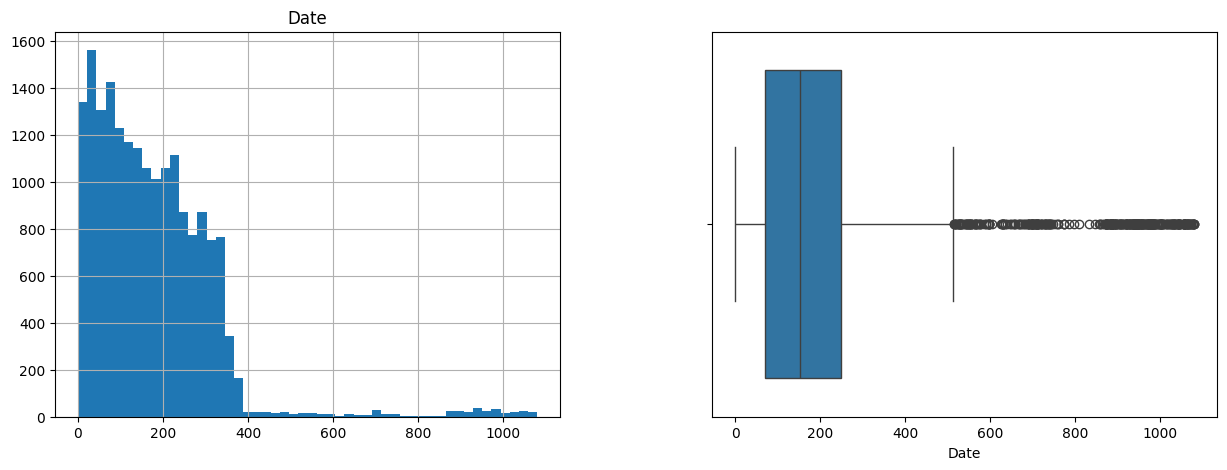

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
dfR[["Date"]].hist(bins=50, ax=axes[0])
sns.boxplot(x=dfR['Date'])



In [11]:
from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin


def find_boxplot_boundaries(
    col: pd.Series, whisker_coeff: float = 1.5
) -> Tuple[float, float]:
    """Findx minimum and maximum in boxplot.

    Args:
        col: a pandas serires of input.
        whisker_coeff: whisker coefficient in box plot
    """
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - whisker_coeff * IQR
    upper = Q3 + whisker_coeff * IQR
    return lower, upper


class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        self.lower, self.upper = find_boxplot_boundaries(X, self.whisker)
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)

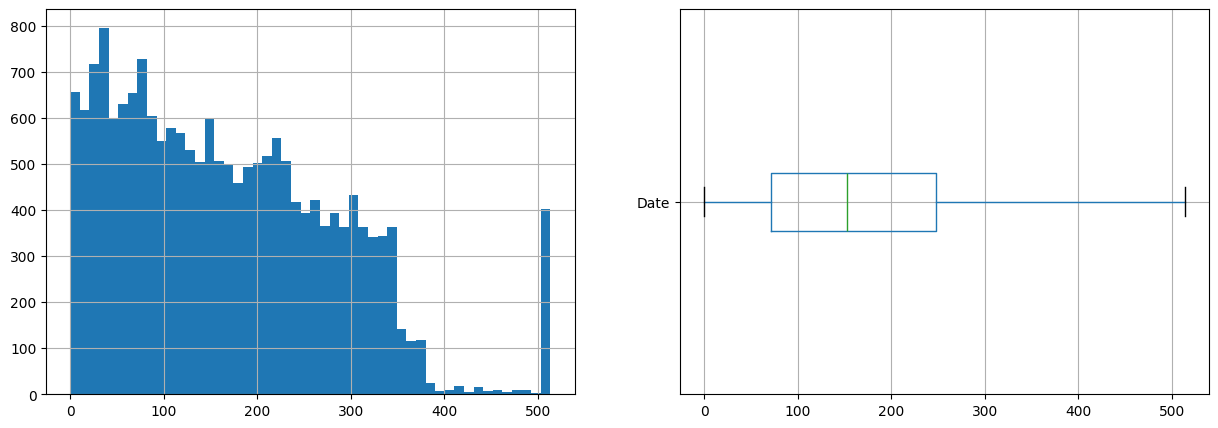

In [12]:
clipped_total_rooms = BoxplotOutlierClipper().fit_transform(dfR["Date"])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
clipped_total_rooms.hist(bins=50, ax=axes[0])
clipped_total_rooms.to_frame().boxplot(ax=axes[1], vert=False);

**Four type of transformation for Recency value**

C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\3267442461.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfR['Date'], hist = False, kde = True,
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\3267442461.py:15: UserWarning: 

`distplot` is a deprec

Lambda value used for Transformation: 0.36312404799786985


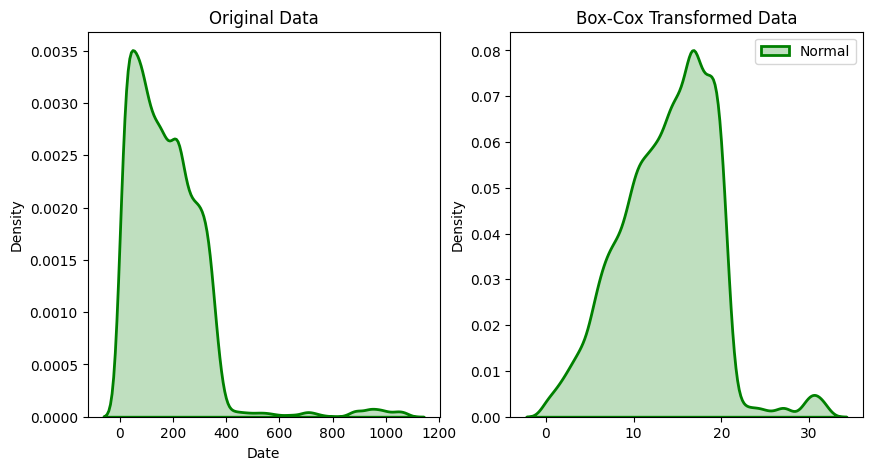

In [13]:
# transform training data & save lambda value
# Add a constant to make all data positive
dfR['Date'] = dfR['Date'] + abs(dfR['Date'].min()) + 1
fitted_dataR, fitted_lambdaR = stats.boxcox(dfR['Date'])
 
# creating axes to draw plots
fig, ax = plt.subplots(1, 2)
 
# plotting the original data(non-normal) and 
# fitted data (normal)
sns.distplot(dfR['Date'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(fitted_dataR, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = ax[1])
 
# adding legends to the subplots
plt.legend(loc = "upper right")

#add title to each histogram
ax[0].set_title('Original Data')
ax[1].set_title('Box-Cox Transformed Data') 
 
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)
 
print(f"Lambda value used for Transformation: {fitted_lambdaR}")
#convert to dataframe
df_fitted_dataR=pd.DataFrame(fitted_dataR)

In [14]:
# Calculate skewness
skewness = skew(dfR['Date'])
# Print the result
print("Skewness:", skewness)
# Calculate skewness
skewnessBC = skew(df_fitted_dataR)
# Print the result
print("Skewness after Box-cox:", skewnessBC)

Skewness: 2.4702740944191635
Skewness after Box-cox: [0.00235188]


C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\2405812207.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfR['Date'], hist = False, kde = True,
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\2405812207.py:13: UserWarning: 

`distplot` is a depreca

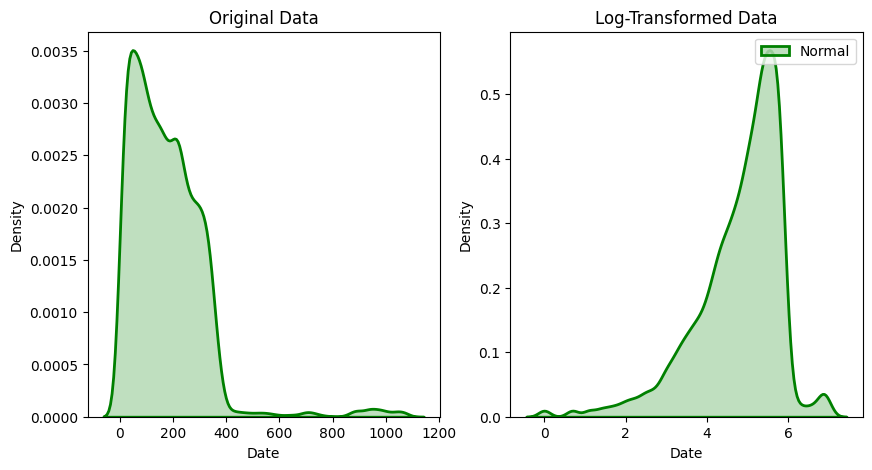

In [15]:
#create log-transformed data
Date_log = np.log(dfR['Date'])

#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

# plotting the original data(non-normal) and 
# fitted data (normal)
sns.distplot(dfR['Date'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax = axs[0])
 
sns.distplot(Date_log, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = axs[1])
 
# adding legends to the subplots
plt.legend(loc = "upper right")

#add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Log-Transformed Data')
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)
 

C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\3574111148.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfR['Date'], hist = False, kde = True,
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\3574111148.py:12: UserWarning: 

`distplot` is a depreca

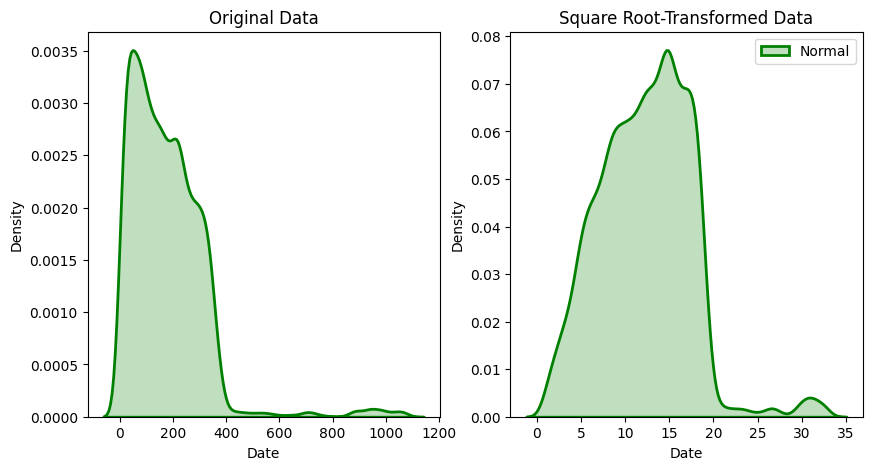

In [16]:
# Create square root-transformed data
Date_sqrt = np.sqrt(dfR['Date'])

# Define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

# Plotting the original data(non-normal) and fitted data (normal)
sns.distplot(dfR['Date'], hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 2}, 
             label = "Non-Normal", color ="green", ax = axs[0])
 
sns.distplot(Date_sqrt, hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 2}, 
             label = "Normal", color ="green", ax = axs[1])
 
# Adding legends to the subplots
plt.legend(loc = "upper right")

# Add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Square Root-Transformed Data')
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\67987116.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfR['Date'], hist = False, kde = True,
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\67987116.py:12: UserWarning: 

`distplot` is a deprecated 

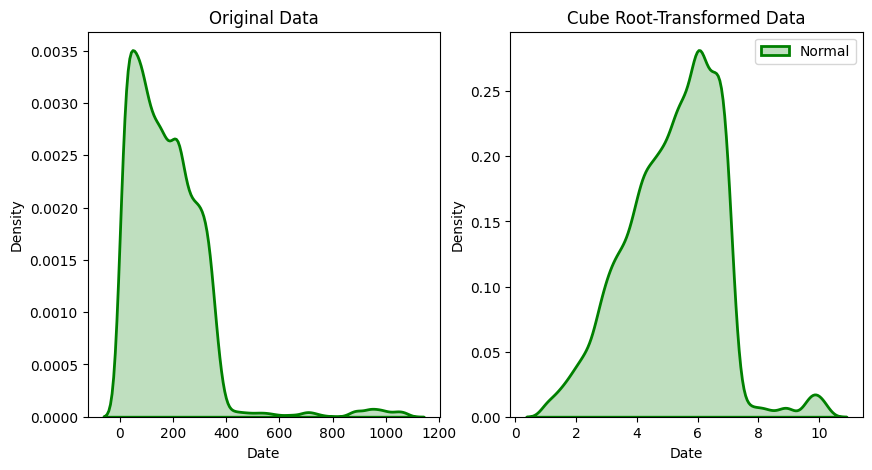

In [17]:
# Create cube root-transformed data
Date_cbrt = np.cbrt(dfR['Date'])

# Define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

# Plotting the original data(non-normal) and fitted data (normal)
sns.distplot(dfR['Date'], hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 2}, 
             label = "Non-Normal", color ="green", ax = axs[0])
 
sns.distplot(Date_cbrt, hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 2}, 
             label = "Normal", color ="green", ax = axs[1])
 
# Adding legends to the subplots
plt.legend(loc = "upper right")

# Add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Cube Root-Transformed Data')
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

**Calculate Frequency**

Frequency of each CustomerKey is calculated by counting unique value of 'Sales Order'.

In [18]:
Frequency = df.drop_duplicates(subset=['Sales Order']).groupby(['CustomerKey'])[['Sales Order']].count()
Frequency

,Sales Order
CustomerKey,
-1,3796
11000,3
11001,3
11002,3
11003,3
...,...
29479,1
29480,1
29481,1


In [177]:
dfF = pd.DataFrame(Frequency)

percentiles = dfF['Sales Order'].quantile([0.25, 0.5, 0.75, 1])
dfF['Sales Order'] = dfF['Sales Order'].astype(int)

dfF['Frequency_Score'] = pd.cut(dfF['Sales Order'], bins=[-float('inf')] + list(percentiles) + [float('inf')], labels=[4, 3, 2, 1], include_lowest=True, duplicates='drop')
dfF

,Sales Order,Frequency_Score
CustomerKey,,
-1,3796,2
11000,3,2
11001,3,2
11002,3,2
11003,3,2
...,...,...
29479,1,4
29480,1,4
29481,1,4


In [20]:
Q1 = dfF['Sales Order'].quantile(0.25)
Q3 = dfF['Sales Order'].quantile(0.75)
IQR = Q3 - Q1
outliers = dfF[(dfF['Sales Order'] < (Q1 - 1.5 * IQR)) | (dfF['Sales Order'] > (Q3 + 1.5 * IQR))]
print(outliers)

             Sales Order Frequency_Score
CustomerKey                             
-1                  3796               2
 11019                17               2
 11078                17               2
 11091                28               2
 11131                 5               2
...                  ...             ...
 15761                 4               2
 15826                 4               2
 16358                 4               2
 16497                 4               2
 16667                 4               2

[246 rows x 2 columns]


<Axes: xlabel='Sales Order'>

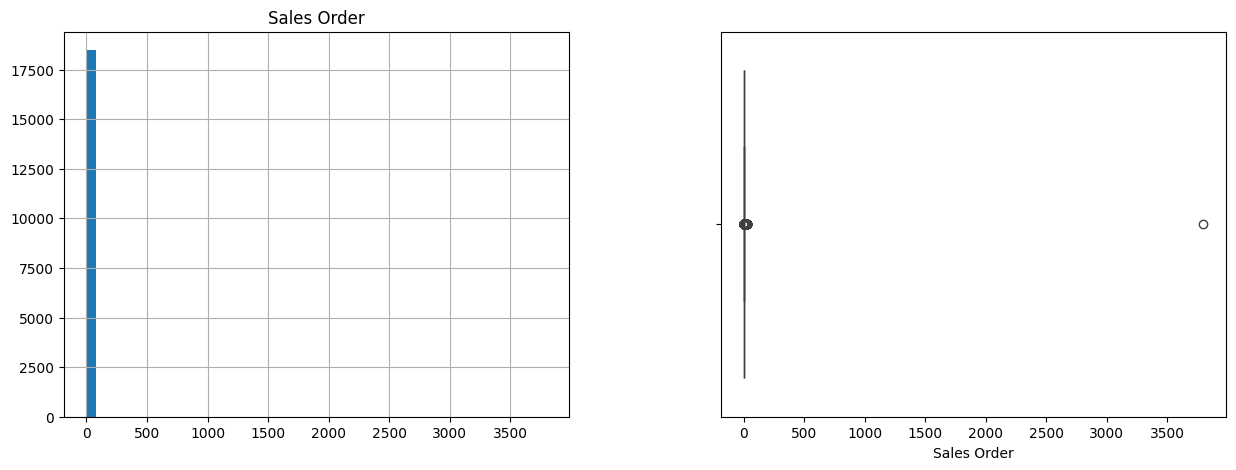

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
dfF[["Sales Order"]].hist(bins=50, ax=axes[0])
sns.boxplot(x=dfF['Sales Order'])

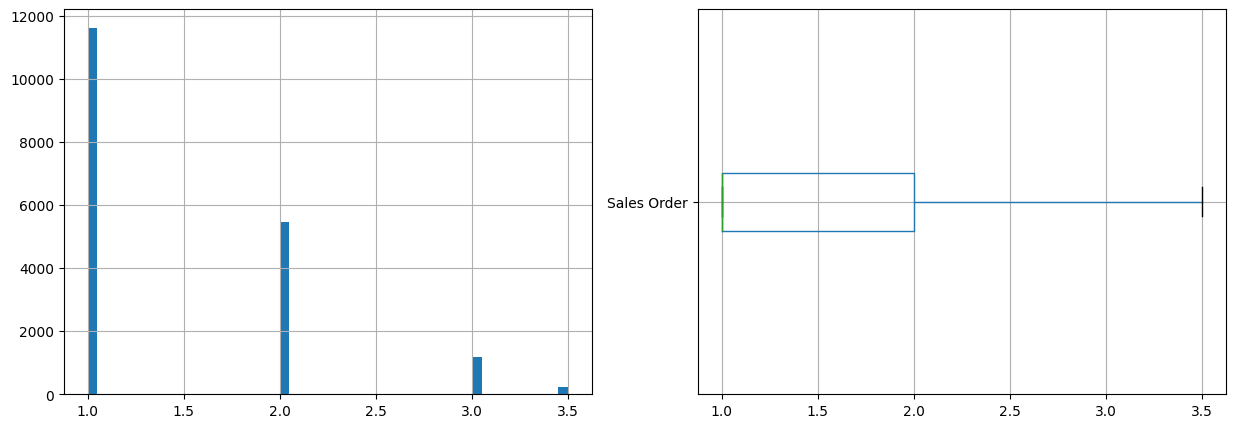

In [22]:
clipped_total_rooms = BoxplotOutlierClipper().fit_transform(dfF["Sales Order"])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
clipped_total_rooms.hist(bins=50, ax=axes[0])
clipped_total_rooms.to_frame().boxplot(ax=axes[1], vert=False);

**Four types of transformation for Frequency value**

C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\1444143630.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfF['Sales Order'], hist = False, kde = True,
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\1444143630.py:15: UserWarning: 

`distplot` is a

Lambda value used for Transformation: -4.689536009646014


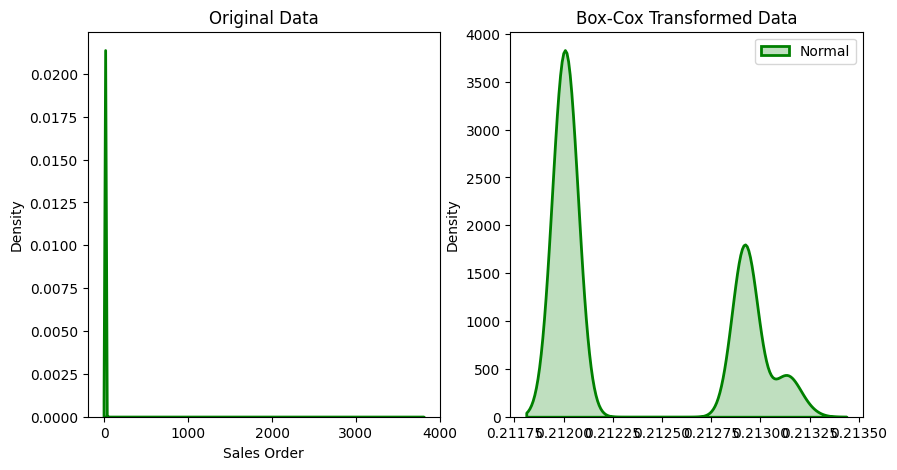

In [23]:
# transform training data & save lambda value
# Add a constant to make all data positive
dfF['Sales Order'] = dfF['Sales Order'] + abs(dfF['Sales Order'].min()) + 1
fitted_dataF, fitted_lambdaF = stats.boxcox(dfF['Sales Order'])
 
# creating axes to draw plots
fig, ax = plt.subplots(1, 2)
 
# plotting the original data(non-normal) and 
# fitted data (normal)
sns.distplot(dfF['Sales Order'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(fitted_dataF, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = ax[1])
 
# adding legends to the subplots
plt.legend(loc = "upper right")

#add title to each histogram
ax[0].set_title('Original Data')
ax[1].set_title('Box-Cox Transformed Data') 
 
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

print(f"Lambda value used for Transformation: {fitted_lambdaF}")
#convert to dataframe
df_fitted_dataF=pd.DataFrame(fitted_dataF)


In [24]:
# Calculate skewness
skewness = skew(dfF['Sales Order'])
# Print the result
print("Skewness:", skewness)
# Calculate skewness
skewnessBC = skew(df_fitted_dataF)
# Print the result
print("Skewness after Box-cox:", skewnessBC)

Skewness: 135.63245167572902
Skewness after Box-cox: [0.57939408]


C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\3812401280.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfF['Sales Order'], hist = False, kde = True,
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\3812401280.py:13: UserWarning: 

`distplot` is a 

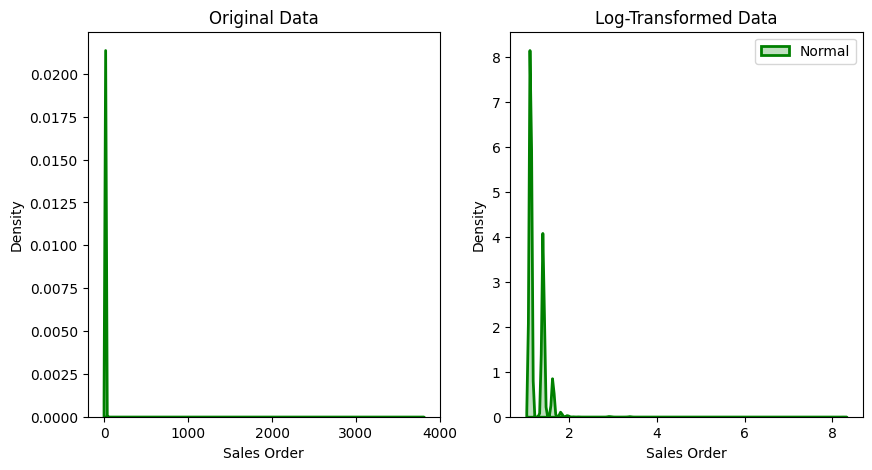

In [25]:
#create log-transformed data
SalesOrder_log = np.log(dfF['Sales Order'])

#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

# plotting the original data(non-normal) and 
# fitted data (normal)
sns.distplot(dfF['Sales Order'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax = axs[0])
 
sns.distplot(SalesOrder_log, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = axs[1])
 
# adding legends to the subplots
plt.legend(loc = "upper right")

#add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Log-Transformed Data')
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\3134102773.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfF['Sales Order'], hist = False, kde = True,
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\3134102773.py:12: UserWarning: 

`distplot` is a 

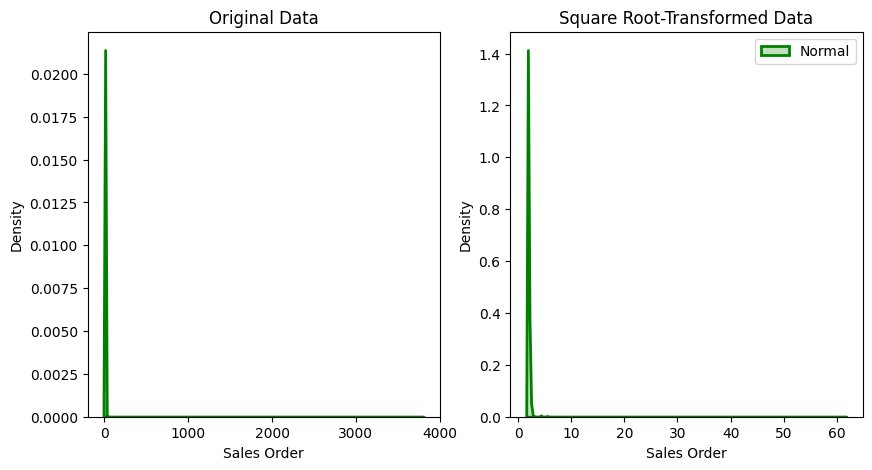

In [26]:
# Create square root-transformed data
SalesOrder_sqrt = np.sqrt(dfF['Sales Order'])

# Define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

# Plotting the original data(non-normal) and fitted data (normal)
sns.distplot(dfF['Sales Order'], hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 2}, 
             label = "Non-Normal", color ="green", ax = axs[0])
 
sns.distplot(SalesOrder_sqrt, hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 2}, 
             label = "Normal", color ="green", ax = axs[1])
 
# Adding legends to the subplots
plt.legend(loc = "upper right")

# Add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Square Root-Transformed Data')
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\2127125989.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfF['Sales Order'], hist = False, kde = True,
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\2127125989.py:12: UserWarning: 

`distplot` is a 

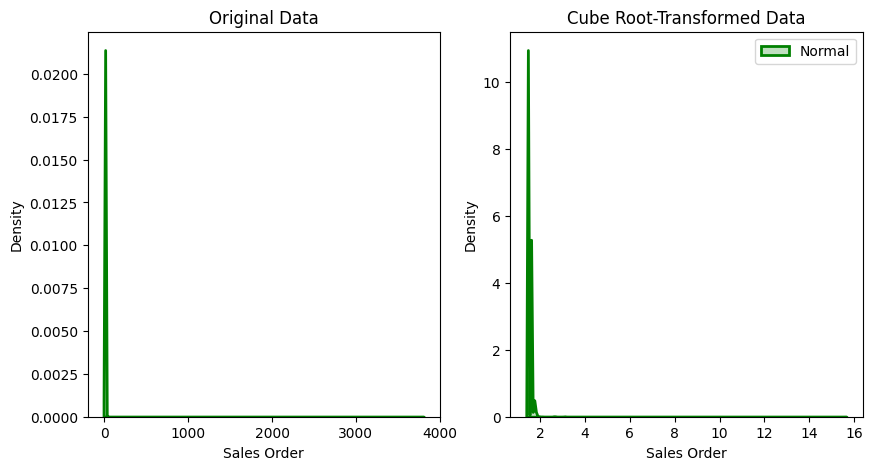

In [27]:
# Create cube root-transformed data
SalesOrder_cbrt = np.cbrt(dfF['Sales Order'])

# Define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

# Plotting the original data(non-normal) and fitted data (normal)
sns.distplot(dfF['Sales Order'], hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 2}, 
             label = "Non-Normal", color ="green", ax = axs[0])
 
sns.distplot(SalesOrder_cbrt, hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 2}, 
             label = "Normal", color ="green", ax = axs[1])
 
# Adding legends to the subplots
plt.legend(loc = "upper right")

# Add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Cube Root-Transformed Data')
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

**Calculate Monetary**

Monentary of each CustomerKey is calculated by summing 'Sales Amount'.

In [28]:
Monetary = df.groupby(['CustomerKey']).agg({'Sales Amount': lambda x: x.sum()})
Monetary.head(15)

,Sales Amount
CustomerKey,
-1,80450596.11
11000,8248.99
11001,6383.88
11002,8114.04
11003,8139.29
11004,8196.01
11005,8121.33
11006,8119.03
11007,8211.00


In [29]:
dfM = pd.DataFrame(Monetary)
dfM['Monetary_Score'] = pd.qcut(dfM['Sales Amount'], q=4, labels=[4, 3, 2, 1])
dfM.head(15)

,Sales Amount,Monetary_Score
CustomerKey,,
-1,80450596.11,1
11000,8248.99,1
11001,6383.88,1
11002,8114.04,1
11003,8139.29,1
11004,8196.01,1
11005,8121.33,1
11006,8119.03,1
11007,8211.00,1


In [30]:
Q1 = dfM['Sales Amount'].quantile(0.25)
Q3 = dfM['Sales Amount'].quantile(0.75)
IQR = Q3 - Q1
outliers = dfM[(dfM['Sales Amount'] < (Q1 - 1.5 * IQR)) | (dfM['Sales Amount'] > (Q3 + 1.5 * IQR))]
print(outliers)

             Sales Amount Monetary_Score
CustomerKey                             
-1            80450596.11              1
 11000            8248.99              1
 11001            6383.88              1
 11002            8114.04              1
 11003            8139.29              1
...                   ...            ...
 18173            7189.35              1
 18177            7043.56              1
 19031            7226.38              1
 19032            6938.58              1
 19614            6217.21              1

[678 rows x 2 columns]


<Axes: xlabel='Sales Amount'>

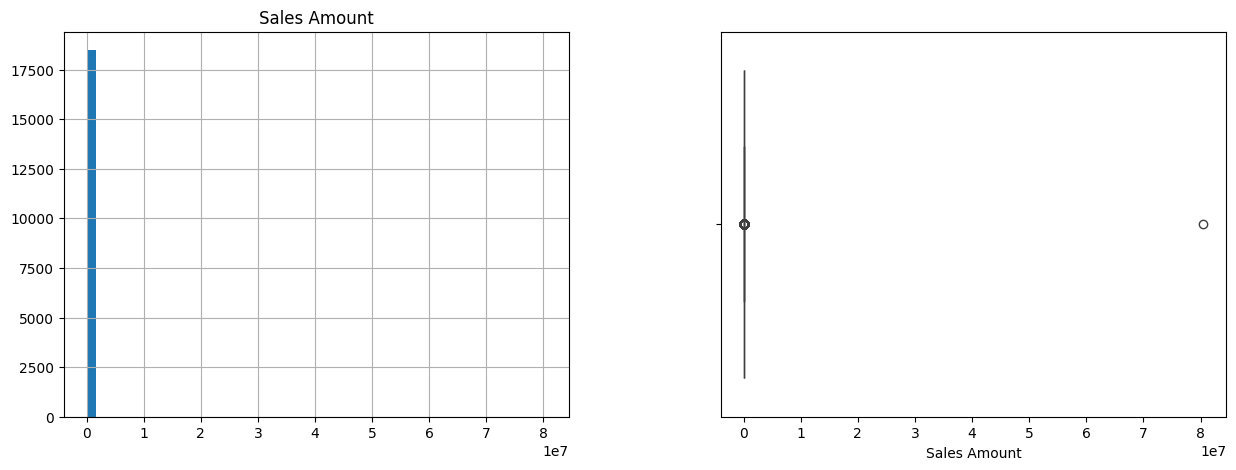

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
dfM[["Sales Amount"]].hist(bins=50, ax=axes[0])
sns.boxplot(x=dfM['Sales Amount'])

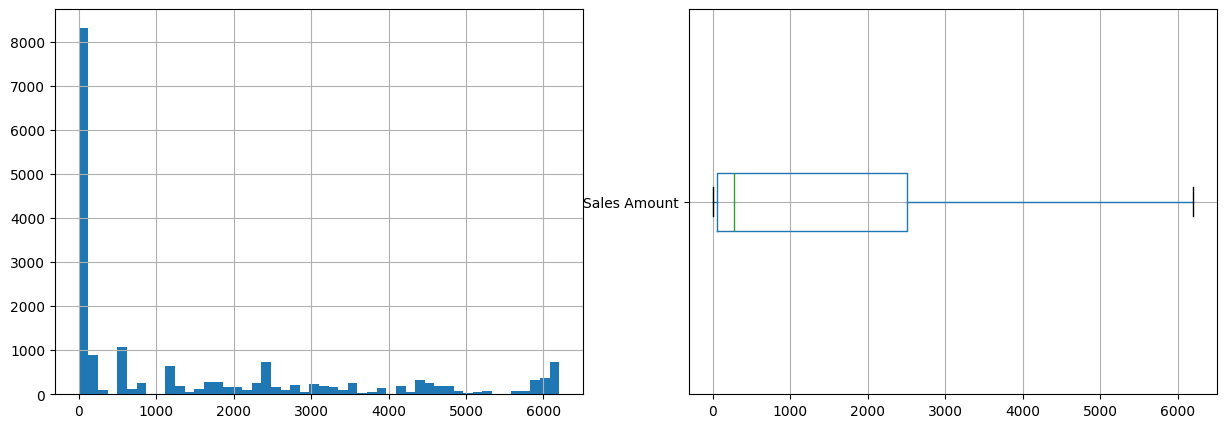

In [32]:
clipped_total_rooms = BoxplotOutlierClipper().fit_transform(dfM["Sales Amount"])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
clipped_total_rooms.hist(bins=50, ax=axes[0])
clipped_total_rooms.to_frame().boxplot(ax=axes[1], vert=False);

**Four types of transformation for Monetary value**

C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\2249710560.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfM['Sales Amount'], hist = False, kde = True,
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\2249710560.py:16: UserWarning: 

`distplot` is 

Lambda value used for Transformation: 0.01173303801318702


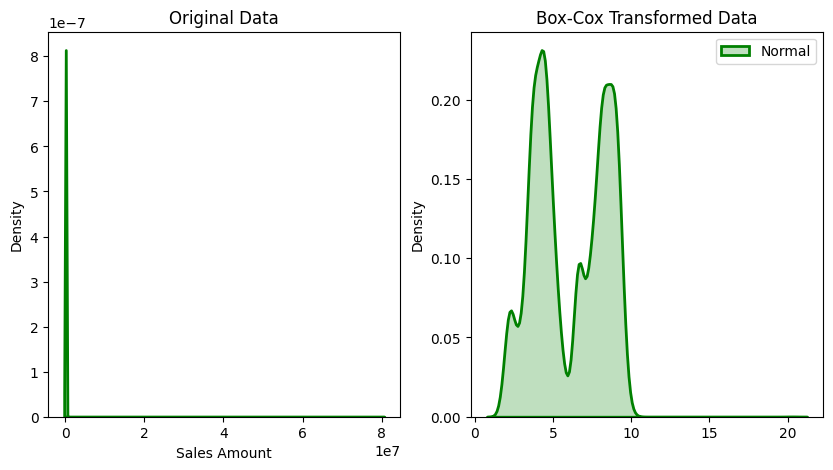

In [33]:
#box-cox transformation
# transform training data & save lambda value
# Add a constant to make all data positive
dfM['Sales Amount'] = dfM['Sales Amount'] + abs(dfM['Sales Amount'].min()) + 1
fitted_dataM, fitted_lambdaM = stats.boxcox(dfM['Sales Amount'])
 
# creating axes to draw plots
fig, ax = plt.subplots(1, 2)
 
# plotting the original data(non-normal) and 
# fitted data (normal)
sns.distplot(dfM['Sales Amount'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(fitted_dataM, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = ax[1])
 
# adding legends to the subplots
plt.legend(loc = "upper right")

#add title to each histogram
ax[0].set_title('Original Data')
ax[1].set_title('Box-Cox Transformed Data') 
 
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

print(f"Lambda value used for Transformation: {fitted_lambdaM}")
#convert to dataframe
df_fitted_dataM=pd.DataFrame(fitted_dataM)

In [34]:
# Calculate skewness
skewness = skew(dfM['Sales Amount'])
print("Skewness:", skewness)

# Calculate skewness
skewnessBC = skew(df_fitted_dataM)
print("Skewness after Box-cox:", skewnessBC)

Skewness: 135.94589169814935
Skewness after Box-cox: [-0.01137952]


C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\737460486.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfM['Sales Amount'], hist = False, kde = True,
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\737460486.py:13: UserWarning: 

`distplot` is a d

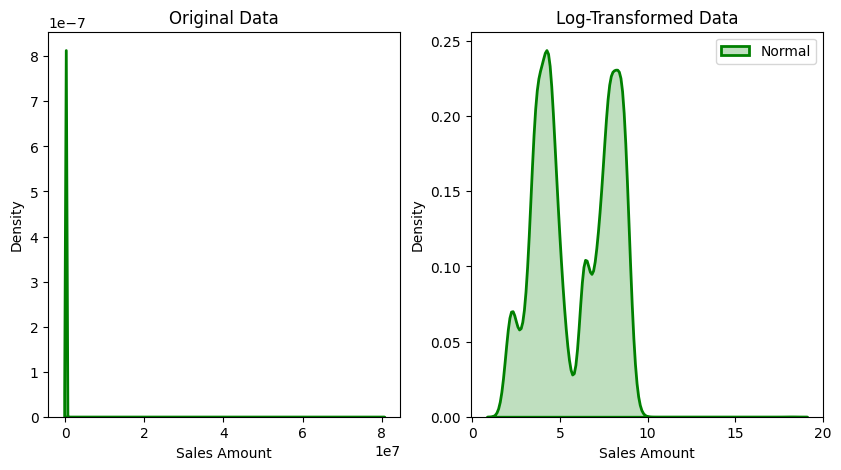

In [35]:
#create log-transformed data
SalesAmount_log = np.log(dfM['Sales Amount'])

#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

# plotting the original data(non-normal) and 
# fitted data (normal)
sns.distplot(dfM['Sales Amount'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax = axs[0])
 
sns.distplot(SalesAmount_log, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = axs[1])
 
# adding legends to the subplots
plt.legend(loc = "upper right")

#add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Log-Transformed Data')
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\2595912645.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfM['Sales Amount'], hist = False, kde = True,
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\2595912645.py:12: UserWarning: 

`distplot` is a

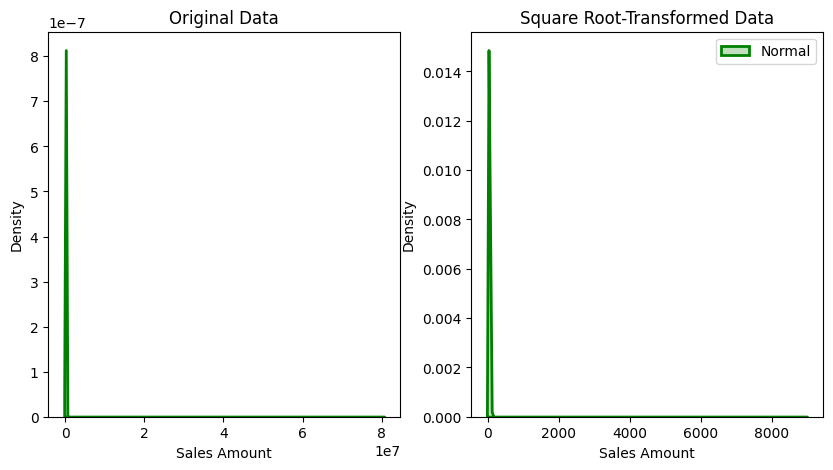

In [36]:
# Create square root-transformed data
SalesAmount_sqrt = np.sqrt(dfM['Sales Amount'])

# Define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

# Plotting the original data(non-normal) and fitted data (normal)
sns.distplot(dfM['Sales Amount'], hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 2}, 
             label = "Non-Normal", color ="green", ax = axs[0])
 
sns.distplot(SalesAmount_sqrt, hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 2}, 
             label = "Normal", color ="green", ax = axs[1])
 
# Adding legends to the subplots
plt.legend(loc = "upper right")

# Add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Square Root-Transformed Data')
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\1781781442.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfM['Sales Amount'], hist = False, kde = True,
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\1781781442.py:12: UserWarning: 

`distplot` is a

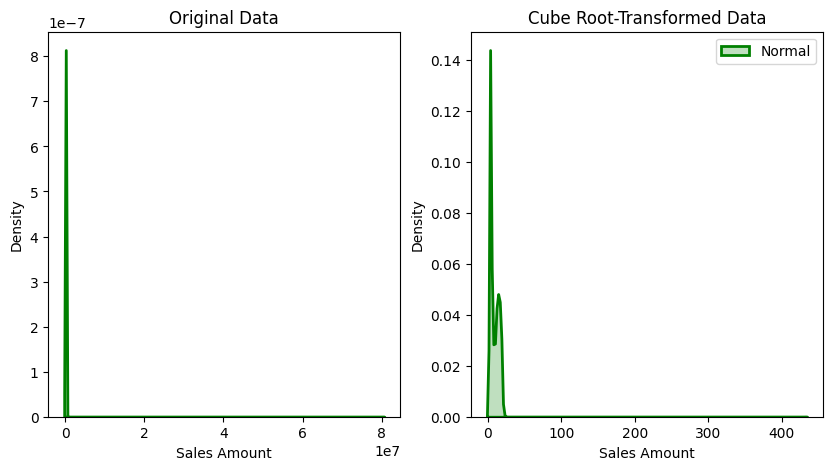

In [37]:
# Create square root-transformed data
SalesAmount_cbrt = np.cbrt(dfM['Sales Amount'])

# Define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

# Plotting the original data(non-normal) and fitted data (normal)
sns.distplot(dfM['Sales Amount'], hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 2}, 
             label = "Non-Normal", color ="green", ax = axs[0])
 
sns.distplot(SalesAmount_cbrt, hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 2}, 
             label = "Normal", color ="green", ax = axs[1])
 
# Adding legends to the subplots
plt.legend(loc = "upper right")

# Add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Cube Root-Transformed Data')
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

In [199]:
RFM = pd.concat([dfR, dfF, dfM], axis=1)
dfR.columns = ['Recency', 'Recency_Score']
dfF.columns = ['Frequency', 'Frequency_Score']
dfM.columns = ['Monetary', 'Monetary_Score']
RFM['RFM_Score'] = RFM['Recency_Score'].astype(str) + RFM['Frequency_Score'].astype(str) + RFM['Monetary_Score'].astype(str)
RFM

,Recency,Recency_Score,Frequency,Frequency_Score,Monetary,Monetary_Score,RFM_Score
CustomerKey,,,,,,,
-1,0,1,3796,2,80450599.40,1,121
11000,255,4,3,2,8252.28,1,421
11001,34,1,3,2,6387.17,1,121
11002,324,4,3,2,8117.33,1,421
11003,248,3,3,2,8142.58,1,321
...,...,...,...,...,...,...,...
29479,496,4,1,4,2052.39,2,442
29480,180,3,1,4,2445.32,2,342
29481,884,4,1,4,3378.28,1,441


**Label and Distribute Customer Segmentation**

In [179]:
seg_map={
    r'[1-2][1-2][1-2]':'Champions',
    r'[1-3][1-3][1-3]':'Loyal customers',
    r'[1-3][1-3][3-4]':'Potential Loyalist',
    r'[1-3][3-4][3-4]':'New Customers',
    r'[1-3][3-4][1-3]':'Promising',
    r'[1-3][2-3][1-3]':'Needing Attention',
    r'[3-4][2-3][1-4]':'At risk',
    r'[3-4]4[1-3]':'Cant Lose Them',
    r'4[1-4][3-4]':'Lost Customers',
}

In [195]:
RFMseg = RFM.copy()
RFMseg = RFMseg.reset_index()
RFMseg = RFMseg[RFMseg['CustomerKey'] != -1]
RFMseg['Segment']=RFMseg['Recency_Score'].astype(str)+RFMseg['Frequency_Score'].astype(str)+RFMseg['Monetary_Score'].astype(str)
RFMseg['Segment']=RFMseg['RFM_Score'].replace(seg_map,regex=True)
RFMseg

,CustomerKey,Recency,Recency_Score,Frequency,Frequency_Score,Monetary,Monetary_Score,RFM_Score,Segment
1,11000,255,4,3,2,8252.28,1,421,At risk
2,11001,34,1,3,2,6387.17,1,121,Champions
3,11002,324,4,3,2,8117.33,1,421,At risk
4,11003,248,3,3,2,8142.58,1,321,Loyal customers
5,11004,257,4,3,2,8199.30,1,421,At risk
...,...,...,...,...,...,...,...,...,...
18480,29479,496,4,1,4,2052.39,2,442,Cant Lose Them
18481,29480,180,3,1,4,2445.32,2,342,Promising
18482,29481,884,4,1,4,3378.28,1,441,Cant Lose Them
18483,29482,482,4,1,4,2052.39,2,442,Cant Lose Them


In [196]:
segment_description=RFMseg.groupby('Segment').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary': ['mean','count']}).round(1)
print(segment_description)

                   Recency Frequency Monetary      
                      mean      mean     mean count
Segment                                            
At risk              306.7       2.0   3874.1  1103
Cant Lose Them       406.5       1.0   1212.9  2269
Champions             71.4       4.0   5865.6   759
Lost Customers       299.5       1.0     28.7  1242
Loyal customers      116.7       2.2   2885.1  4818
New Customers        118.5       1.0     53.1  5379
Potential Loyalist    95.2       2.0     42.9   185
Promising            118.9       1.0   1360.6  2729


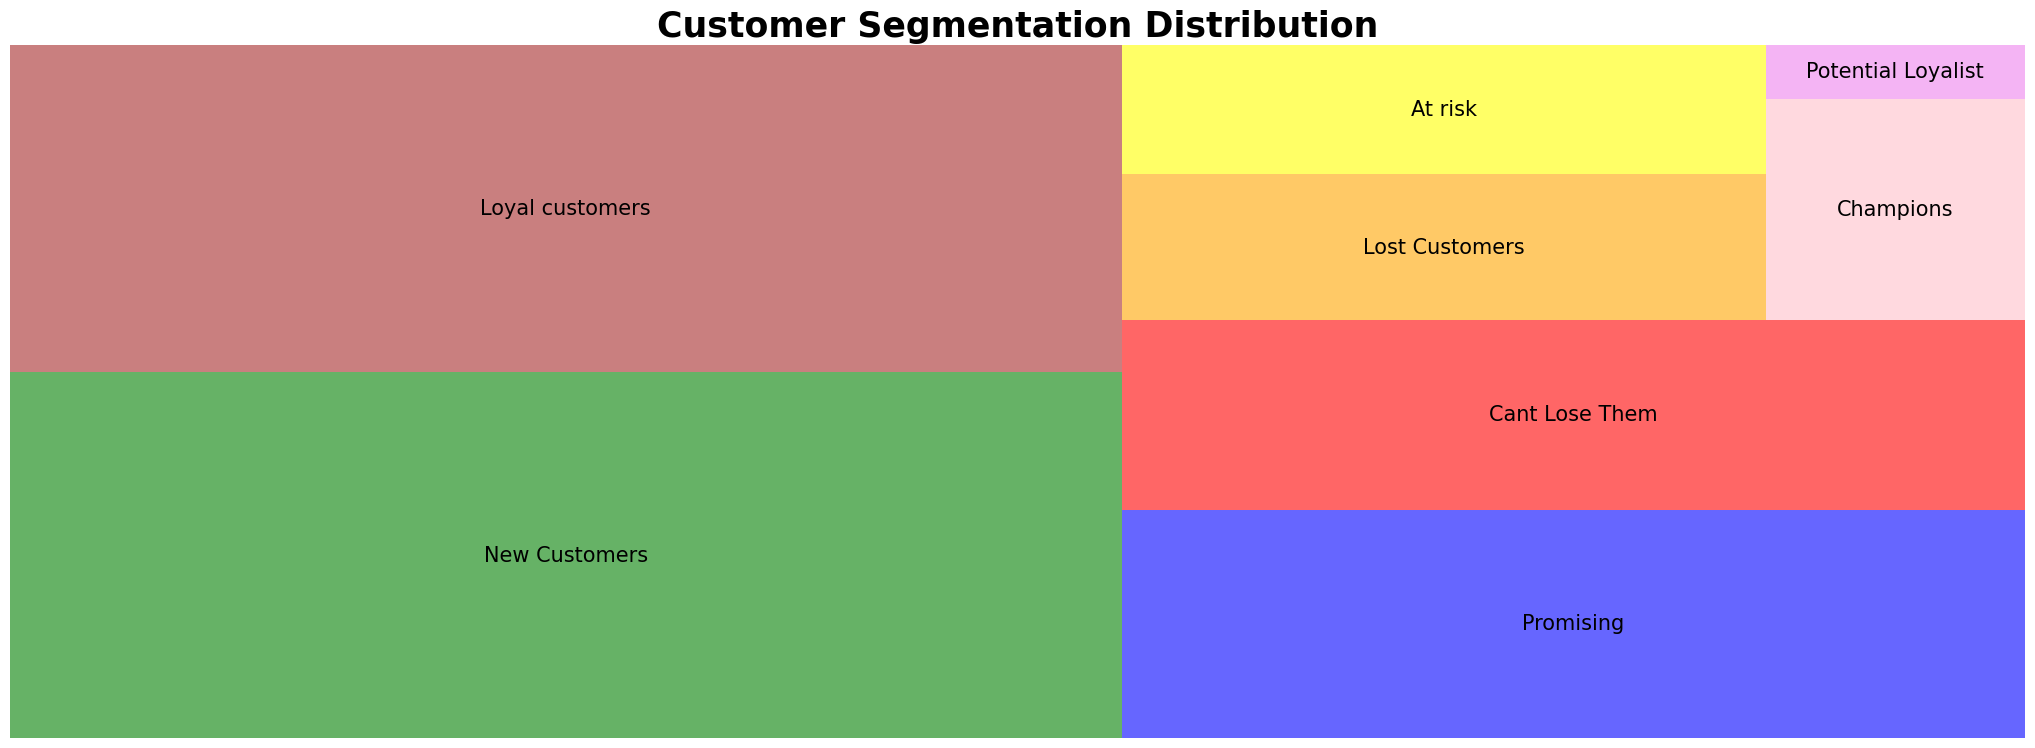

In [197]:
import squarify
#RFMseg['Segment'].describe().astype('int32')
# Count the number of customers in each segment
segment_counts = RFMseg['Segment'].value_counts()
# segment_description.columns = rfm_level_agg.columns.droplevel()
# rfm_level_agg.columns=['RecencyMean','FrequencyMean','MonetaryMean','Count']
#create our plot and resize it
fig=plt.gcf()
ax=fig.add_subplot()
fig.set_size_inches(26,9)

# Draw a treemap
squarify.plot(sizes=segment_counts, label=segment_counts.index, alpha=0.6, color=['green','brown','blue','red','orange','yellow','pink','violet'], text_kwargs={'fontsize':15})

plt.title("Customer Segmentation Distribution", fontsize=25, fontweight="bold")
plt.axis('off')
plt.show()

**Create Scatter Plot to explore the correlation**

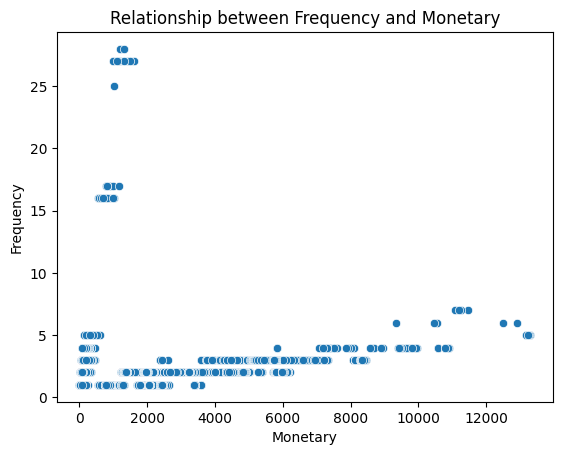

In [200]:
# Create scatter plot 
sns.scatterplot(x='Monetary', y='Frequency', data=RFM.iloc[1:])

# Add labels and title
plt.xlabel('Monetary')
plt.ylabel('Frequency')
plt.title('Relationship between Frequency and Monetary')

# Show the plot
plt.show()

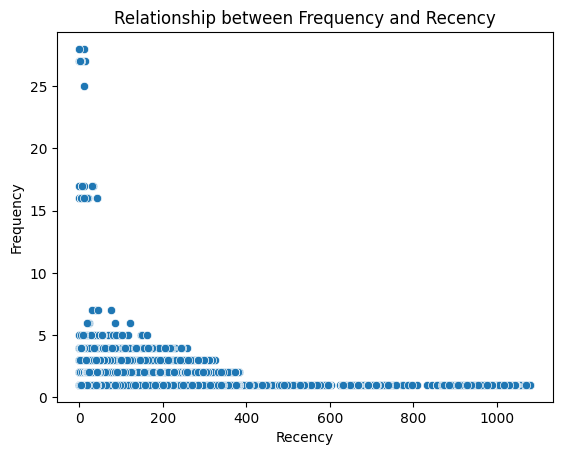

In [201]:
# Create scatter plot 
sns.scatterplot(x='Recency', y='Frequency', data=RFM.iloc[1:])

# Add labels and title
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Relationship between Frequency and Recency')

# Show the plot
plt.show()

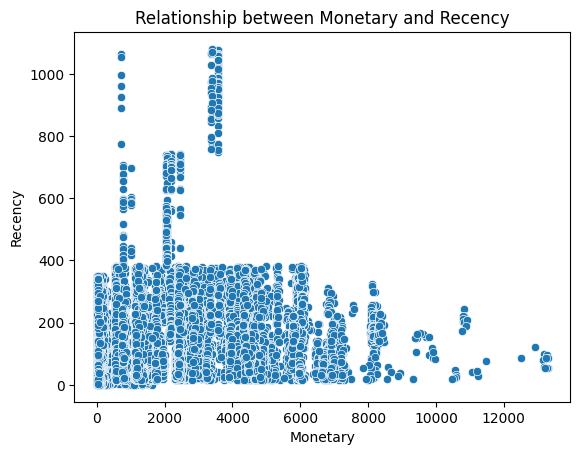

In [202]:
# Create scatter plot
sns.scatterplot(y='Recency', x='Monetary', data=RFM.iloc[1:])

# Add labels and title
plt.xlabel('Monetary')
plt.ylabel('Recency')
plt.title('Relationship between Monetary and Recency')

# Show the plot
plt.show()

**Dataframe after Box-cox transformation**

In [209]:
#dataframe after Box-cox transformation
# Reset index of dfR to make 'CustomerKey' a column
dfR_reset = dfR.reset_index()

RFMBC = pd.concat([df_fitted_dataR, df_fitted_dataF , df_fitted_dataM], axis=1)
RFMBC.columns = ['Recency', 'Frequency', 'Monetary']
# Merge RFMBC with dfR_reset on 'CustomerKey'
RFMBC = pd.merge(dfR_reset[['CustomerKey']], RFMBC , left_index=True, right_index=True)

RFMBC


,CustomerKey,Recency,Frequency,Monetary
0,-1,0.000000,0.213241,20.293161
1,11000,17.873061,0.213128,9.512644
2,11001,7.260711,0.213128,9.228279
3,11002,19.740304,0.213128,9.494318
4,11003,17.666443,0.213128,9.497769
...,...,...,...,...
18480,29479,23.491740,0.212006,7.978411
18481,29480,15.433175,0.212006,8.170177
18482,29481,29.609283,0.212006,8.525022
18483,29482,23.220832,0.212006,7.978411


In [204]:
# Convert int64 columns to int32 and float64 columns to float32
RFMBC = RFMBC.astype({col: 'int32' if RFMBC[col].dtype == 'int64' else 'float32' for col in RFMBC.columns})
print(RFMBC.dtypes)

CustomerKey      int32
Recency        float32
Frequency      float32
Monetary       float32
dtype: object


**Scalling data by using Z - score**

In [205]:
# Remove rows where 'CustomerKey' equals -1
RFMBC = RFMBC[RFMBC['CustomerKey'] != -1]
RFMz=RFMBC.drop('CustomerKey', axis=1)
data_scaled = RFMz.apply(stats.zscore)
print(data_scaled)
data_scaled.describe().astype('int32')

        Recency  Frequency  Monetary
1      0.756758   1.639472  1.530494
2     -1.247743   1.639472  1.404408
3      1.109449   1.639472  1.522368
4      0.717731   1.639472  1.523899
5      0.767783   1.639472  1.527320
...         ...        ...       ...
18480  1.818034  -0.763289  0.850223
18481  0.295903  -0.763289  0.935251
18482  2.973539  -0.763289  1.092587
18483  1.766864  -0.763289  0.850223
18484  1.799866  -0.763289  0.850223

[18484 rows x 3 columns]


,Recency,Frequency,Monetary
count,18484,18484,18484
mean,0,0,0
std,1,1,1
min,-2,0,-1
25%,0,0,0
50%,0,0,0
75%,0,1,0
max,3,1,1


**Choosing the number of clusters**

First, we use Elbow to determine the number K, then we use Silhouette to fine the best number of clusters and confirm the K-number.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

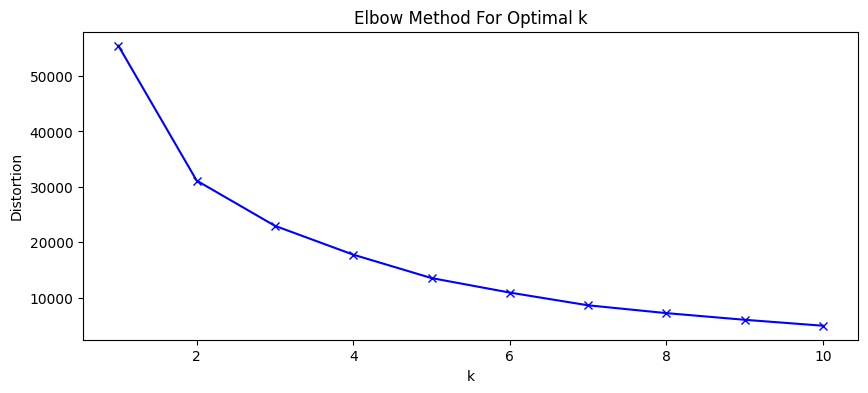

In [129]:
from sklearn.cluster import KMeans
# Create a list to store the sum of squared distances
ssd = []

# Define the range of potential clusters to test
range_n_clusters = list(range(1,11))

# Use the KMeans algorithm to calculate SSD for different numbers of clusters
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(data_scaled)
    
    ssd.append(kmeans.inertia_)
    
# Add labels and title
plt.figure(figsize=(10,4))
# Plot SSDs for each n_clusters
plt.plot(range_n_clusters, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')

# Show the plot
plt.show()

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

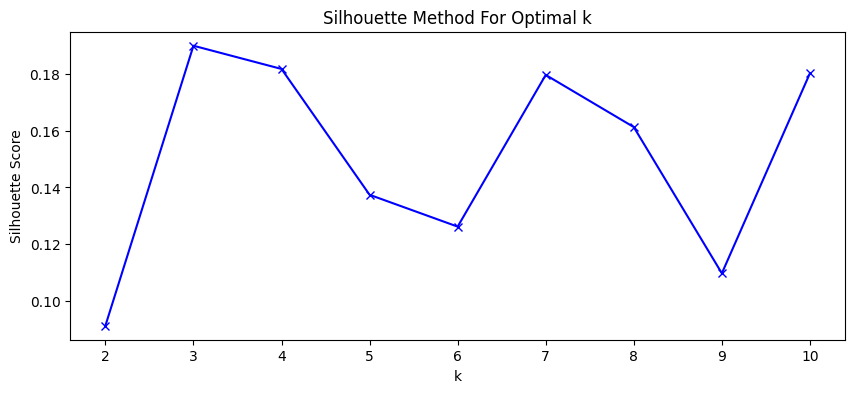

Best number of clusters: 3


In [130]:
from sklearn.metrics import silhouette_score

# Create a list to store the silhouette scores
silhouette_scores = []

# Define the range of potential clusters to test
range_n_clusters = list(range(2,11))

# Use the KMeans algorithm to calculate silhouette scores for different numbers of clusters
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(data_scaled)
    
    cluster_labels = kmeans.labels_
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(RFMz, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
# Plot silhouette scores for each n_clusters
plt.figure(figsize=(10,4))
plt.plot(range_n_clusters, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')

# Show the plot
plt.show()
best_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Best number of clusters: {best_n_clusters}")

In [143]:
model= KMeans(n_clusters = 3, max_iter = 300)
model.fit(data_scaled)

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

In [206]:
# Create a copy of RFM
RFM1 = RFM.copy()
RFM1 = RFM1.reset_index()
RFM1_filtered = RFM1[RFM1['CustomerKey'] != -1]
# Assign the label
RFM1_filtered['Cluster_ID'] = model.labels_ + 1

RFM1_filtered

C:\Users\DELL\AppData\Local\Temp\ipykernel_30868\1837835736.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFM1_filtered['Cluster_ID'] = model.labels_ + 1


,CustomerKey,Recency,Recency_Score,Frequency,Frequency_Score,Monetary,Monetary_Score,RFM_Score,Cluster_ID
1,11000,255,4,3,2,8252.28,1,421,3
2,11001,34,1,3,2,6387.17,1,121,3
3,11002,324,4,3,2,8117.33,1,421,3
4,11003,248,3,3,2,8142.58,1,321,3
5,11004,257,4,3,2,8199.30,1,421,3
...,...,...,...,...,...,...,...,...,...
18480,29479,496,4,1,4,2052.39,2,442,2
18481,29480,180,3,1,4,2445.32,2,342,2
18482,29481,884,4,1,4,3378.28,1,441,2
18483,29482,482,4,1,4,2052.39,2,442,2


In [207]:
# Count the number of customers in each cluster
cluster_counts = RFM1_filtered['Cluster_ID'].value_counts()

# Print the cluster counts
print(cluster_counts)

Cluster_ID
2    7315
3    6456
1    4713
Name: count, dtype: int64


**K-Means clustering**

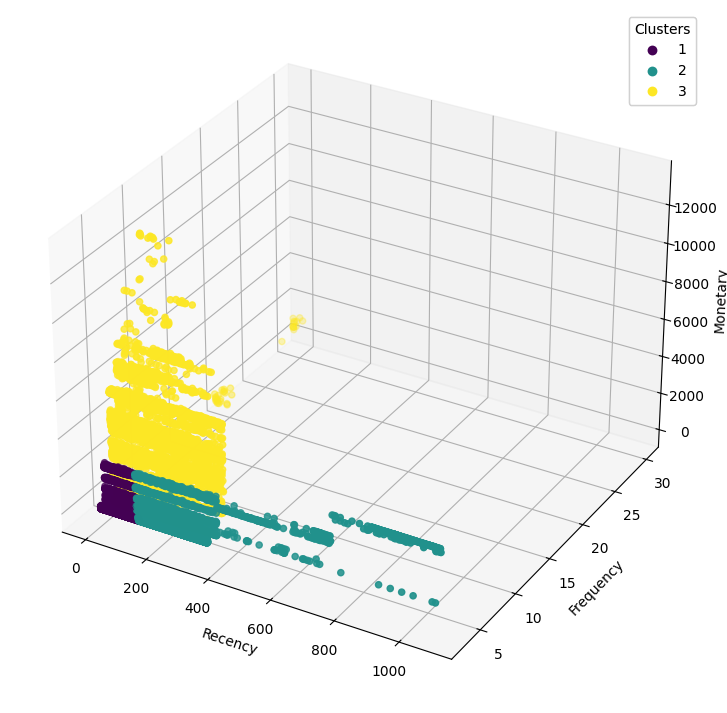

In [165]:
from mpl_toolkits.mplot3d import Axes3D
# Exclude rows where 'CustomerKey' equals -1
# RFM1 = RFM1.reset_index()
# RFM1_filtered = RFM1[RFM1['CustomerKey'] != -1]

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot the filtered DataFrame
scatter = ax.scatter(RFM1_filtered['Recency'], RFM1_filtered['Frequency'], RFM1_filtered['Monetary'], c=RFM1_filtered['Cluster_ID'])

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# Create a legend for the colors
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.show()

**Descriptive analysis of each cluster**

There are 3 clusters, in this section, we count the number of customers each cluster and calculate descriptive values for each one.

In [167]:
cluster_means=RFM1_filtered.groupby('Cluster_ID').agg(
    {
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary': 'mean'
    }
).round(2)
cluster_means = cluster_means.rename(columns={'Date': 'Recency', 'Sales Order': 'Frequency', 'Sales Amount': 'Monetary'})
print(cluster_means)

            Recency  Frequency  Monetary
Cluster_ID                              
1             56.87       3.09    490.72
2            274.64       3.00    616.97
3            150.26       4.35   3499.62


In [163]:
# Select 'Date', 'Sales Order', and 'Sales Amount' columns and group by 'Cluster_ID'
cluster1_descriptions = RFM1_filtered[RFM1_filtered['Cluster_ID'] == 1][['Recency', 'Frequency', 'Monetary']].describe()

# Print the cluster descriptions
print(cluster1_descriptions)

           Recency    Frequency     Monetary
count  4713.000000  4713.000000  4713.000000
mean     56.870783     3.089964   490.720600
std      36.021417     0.302738   766.163084
min       1.000000     3.000000     5.580000
25%      25.000000     3.000000    38.280000
50%      55.000000     3.000000    73.280000
75%      87.000000     3.000000   592.250000
max     129.000000     6.000000  2568.210000


In [164]:
# Select 'Date', 'Sales Order', and 'Sales Amount' columns and group by 'Cluster_ID'
cluster2_descriptions = RFM1_filtered[RFM1_filtered['Cluster_ID'] == 2][['Recency', 'Frequency', 'Monetary']].describe()

# Print the cluster descriptions
print(cluster2_descriptions)

           Recency    Frequency     Monetary
count  7315.000000  7315.000000  7315.000000
mean    274.635407     3.000957   616.972395
std     159.196371     0.030922   941.091897
min     118.000000     3.000000     5.580000
25%     185.000000     3.000000    38.270000
50%     244.000000     3.000000    75.240000
75%     309.000000     3.000000   784.095000
max    1081.000000     4.000000  3581.560000


In [168]:
# Select 'Date', 'Sales Order', and 'Sales Amount' columns and group by 'Cluster_ID'
cluster3_descriptions = RFM1_filtered[RFM1_filtered['Cluster_ID'] == 3][['Recency', 'Frequency', 'Monetary']].describe()

# Print the cluster descriptions
print(cluster3_descriptions)

           Recency    Frequency      Monetary
count  6456.000000  6456.000000   6456.000000
mean    150.256660     4.354399   3499.623759
std      95.002287     1.506255   2426.120713
min       1.000000     4.000000     17.850000
25%      71.000000     4.000000   1477.842500
50%     137.000000     4.000000   3615.495000
75%     217.000000     4.000000   5317.540000
max     382.000000    30.000000  13298.670000


**Evaluation**

In this part, we use mutual_info_score to evaluate the accuracy of the model.
 

In [208]:
# Convert to integers
RFM1_int = RFM1_filtered.astype(int)


from sklearn.metrics import mutual_info_score 
  
misR = mutual_info_score(RFM1_int['Recency'], model.labels_) 
print(misR) 
misF = mutual_info_score(RFM1_int['Frequency'], model.labels_) 
print(misF)
misM = mutual_info_score(RFM1_int['Monetary'], model.labels_)
print(misM)

0.4661767165325351
0.5847359702874757
0.564179530090875


In [216]:
from sklearn.metrics import adjusted_rand_score

# Calculate the ARI for 'Recency'
ariR = adjusted_rand_score(RFM1_int['Recency'], model.labels_)
print(ariR)

# Calculate the ARI for 'Frequency'
ariF = adjusted_rand_score(RFM1_int['Frequency'], model.labels_)
print(ariF)

# Calculate the ARI for 'Monetary'
ariM = adjusted_rand_score(RFM1_int['Monetary'], model.labels_)
print(ariM)

0.00321683213985857
0.49657597114951674
0.005423026490533473


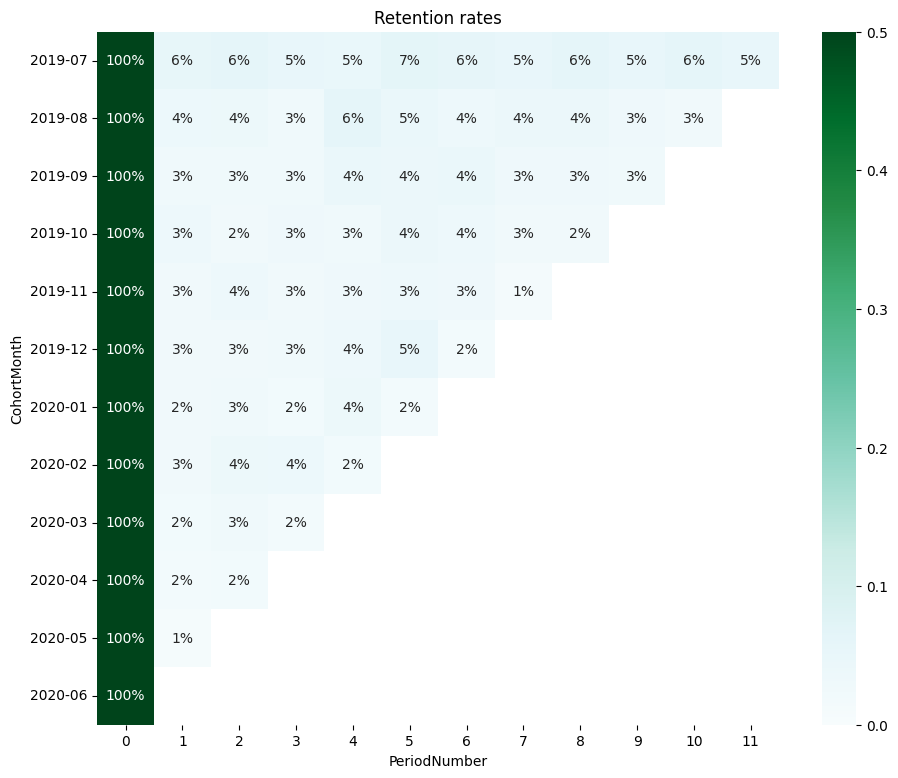

In [215]:
from operator import attrgetter

df1 = df.copy()
# Convert the 'Date' column to datetime if it's not already
df1['Date'] = pd.to_datetime(df1['Date'])
# Filter the DataFrame to only include data from 15th July 2019 to 15th June 2020
df1 = df1[(df1['Date'] >= '2019-07-15') & (df1['Date'] <= '2020-06-15')]

# Create a 'CohortMonth' column that represents the month of first purchase
df1['OrderMonth'] = df1['Date'].dt.to_period('M')
df1['CohortMonth'] = df1.groupby('CustomerKey')['OrderMonth'].transform('min')

# Create a cohort table
df_cohort = df1.groupby(['CohortMonth', 'OrderMonth']).agg(n_customers=('CustomerKey', 'nunique')).reset_index(drop=False)
df_cohort['PeriodNumber'] = (df_cohort.OrderMonth - df_cohort.CohortMonth).apply(attrgetter('n'))

# Pivot the cohort table
cohort_pivot = df_cohort.pivot_table(index = 'CohortMonth',
                                     columns = 'PeriodNumber',
                                     values = 'n_customers')

# Calculate the retention rate
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

# Plot the retention matrix
plt.figure(figsize = (11,9))
plt.title('Retention rates')
sns.heatmap(data = retention_matrix, annot = True, fmt = '.0%', vmin = 0.0, vmax = 0.5, cmap = 'BuGn')
plt.show()